In [1]:
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats.contingency import relative_risk
from scipy.stats import fisher_exact
from pandas.plotting import table
import zepid
from zepid.graphics import EffectMeasurePlot
import umap.umap_ as umap
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.manifold import MDS
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [98]:
sil_cos = pd.read_csv('disease_groupwise_similarities_files/cos_sil_and_names.csv',
                   index_col = [0])

sil_wang = pd.read_csv('disease_groupwise_similarities_files/wang_sil_and_names.csv',
                   index_col = [0])

wang_dsims = pd.read_csv("disease_groupwise_similarities_files/wang_dsims.csv",
                   index_col = [0])

cos_dsims = pd.read_csv("disease_groupwise_similarities_files/wang_dsims.csv",
                   index_col = [0])

patient_dissimilarity = pd.read_csv("/Users/lucasgomesmaddalena/Library/CloudStorage/OneDrive-Pessoal/Documentos/PUC 22.1/TCC/Groupwise_Dissimilarity_All_Patients.csv",
                   index_col = [0])

data = pd.read_csv('data.csv',
                   index_col = [0]) #raw SIVEP-Gripe dataser

semantic_cluster = pd.read_csv('disease_groupwise_similarities_files/semantic_clusters.csv',
                               index_col = [0]) #semantic cluster data

no_semantic_cluster = pd.read_csv('disease_groupwise_similarities_files/no_semantic_clusters.csv',
                                  index_col = [0]) #no semantics cluster data

idx = pd.read_csv('disease_groupwise_similarities_files/binary_with_index.csv',
                  index_col = [0])['c_idx'].map(int) #disease group idx

data['comb_idx'] = data.index.map(idx) #insert dis group idx to raw data

data['sem_cluster'] = data['comb_idx'].map(semantic_cluster.to_dict()['cluster'])

data['no_sem_cluster'] = data['comb_idx'].map(no_semantic_cluster.to_dict()['cluster'])

diseases_names = pd.read_csv('disease_groupwise_similarities_files/disease_names.csv'
                             ,index_col=[0])

# Death Analysis

In [5]:
transform = {1.0: 0, 2.0: 1, 9.0: 0, 3.0: 0}
data['DEATH_CASE'] = data['EVOLUCAO'].fillna(0).map(lambda x: 1 if x == 2 else 0)

In [6]:
sem_OR_data = dict.fromkeys(data['sem_cluster'].unique())

for k in data['sem_cluster'].unique():
    n00 = len(data[(data['sem_cluster'] == k) & (data['DEATH_CASE'] == 1)]['DEATH_CASE'])
    n01 = len(data[(data['sem_cluster'] == k) & (data['DEATH_CASE'] != 1)]['DEATH_CASE'])
    n10 = len(data[(data['sem_cluster'] != k) & (data['DEATH_CASE'] == 1)]['DEATH_CASE'])
    n11 = len(data[(data['sem_cluster'] != k) & (data['DEATH_CASE'] != 1)]['DEATH_CASE'])
    
    oddsr, p = fisher_exact(np.array([n00,
                                      n10 + n00,
                                      n01,
                                      n01 + n11]).reshape(2,2),
                            alternative='two-sided')
    
    result = relative_risk(n00, n10 + n00, n01, n01 + n11)
    LB,UP = result.confidence_interval(confidence_level=0.95)
    sem_OR_data[k] = [LB,result.relative_risk,UP,p]
    
no_sem_OR_data = dict.fromkeys(data['no_sem_cluster'].unique())

for k in data['no_sem_cluster'].unique():
    n00 = len(data[(data['no_sem_cluster'] == k) & (data['DEATH_CASE'] == 1)]['DEATH_CASE'])
    n01 = len(data[(data['no_sem_cluster'] == k) & (data['DEATH_CASE'] != 1)]['DEATH_CASE'])
    n10 = len(data[(data['no_sem_cluster'] != k) & (data['DEATH_CASE'] == 1)]['DEATH_CASE'])
    n11 = len(data[(data['no_sem_cluster'] != k) & (data['DEATH_CASE'] != 1)]['DEATH_CASE'])
    
    oddsr, p = fisher_exact(np.array([n00,
                                      n10 + n00,
                                      n01,
                                      n01 + n11]).reshape(2,2),
                            alternative='two-sided')
    
    result = relative_risk(n00, n10 + n00, n01, n01 + n11)
    LB,UP = result.confidence_interval(confidence_level=0.95)
    no_sem_OR_data[k] = [LB,result.relative_risk,UP,p]

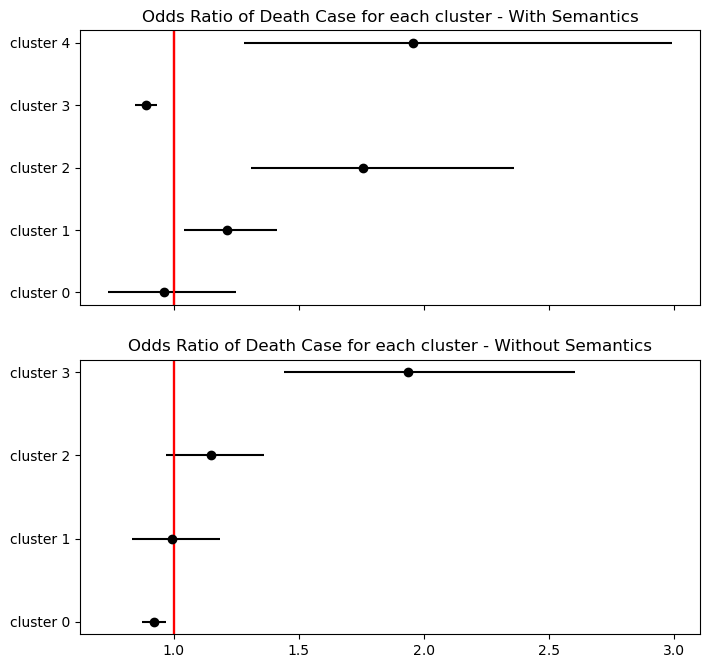

In [7]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8),dpi=100,sharex=True)

ax1.set_yticks(data['sem_cluster'].sort_values(ascending=False).unique())
ax2.set_yticks(data['no_sem_cluster'].sort_values(ascending=False).unique())

for k in data['sem_cluster'].sort_values(ascending=False).unique():
    
    ax1.set_title("Odds Ratio of Death Case for each cluster - With Semantics")

    ax1.errorbar(x = sem_OR_data[k][1],
                 y = k,
                 xerr = np.array([sem_OR_data[k][1] - sem_OR_data[k][0],
                                  sem_OR_data[k][2] - sem_OR_data[k][1]]).reshape(2,1),
                 fmt = 'o',
                 color = 'k')

    ax1.axvline(1,color='red')
    

for k in data['no_sem_cluster'].sort_values(ascending=False).unique():
    ax2.set_title("Odds Ratio of Death Case for each cluster - Without Semantics")

    ax2.errorbar(x = no_sem_OR_data[k][1],
                 y = k,
                 xerr = np.array([no_sem_OR_data[k][1] - no_sem_OR_data[k][0],
                                  no_sem_OR_data[k][2] - no_sem_OR_data[k][1]]).reshape(2,1),
                 fmt = 'o',
                 color = 'k')

    ax2.axvline(1,color='red')

ax1.set_yticklabels(['cluster %i'%k for k in data['sem_cluster'].sort_values(ascending=False).unique()])
ax2.set_yticklabels(['cluster %i'%k for k in data['no_sem_cluster'].sort_values(ascending=False).unique()])

plt.show()

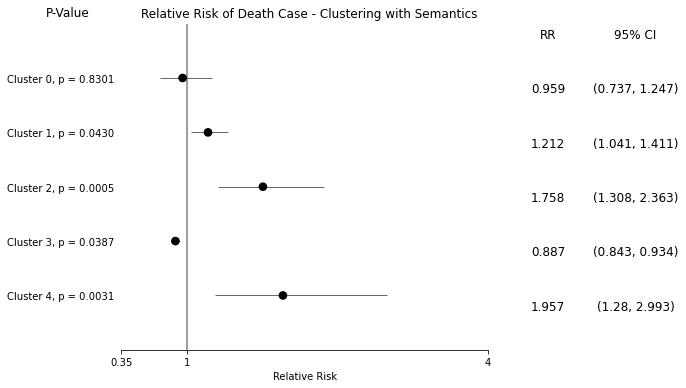

In [8]:
labs = ["Cluster %i, p = %.4f"%(i,sem_OR_data[i][3]) for i in [0,1,2,3,4]]

measure = [sem_OR_data[i][1] for i in [0,1,2,3,4]]
lower = [sem_OR_data[i][0] for i in [0,1,2,3,4]]
upper = [sem_OR_data[i][2] for i in [0,1,2,3,4]]

p = EffectMeasurePlot(label=labs, effect_measure=measure, lcl=lower, ucl=upper)
p.labels(effectmeasure='RR')
p.colors(pointshape="o")
ax = p.plot(figsize=(10,6), t_adjuster=0.05, max_value=4, min_value=0.35)
plt.title("Relative Risk of Death Case - Clustering with Semantics",loc="right",x=-0.15, y=1)
plt.suptitle("P-Value",x=0.05,y=0.92)
ax.set_xlabel("Relative Risk", fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.show()

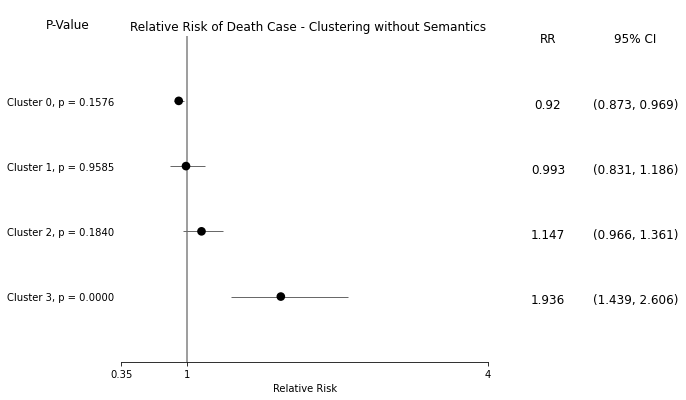

In [9]:
labs = ["Cluster %i, p = %.4f"%(i,no_sem_OR_data[i][3]) for i in [0,1,2,3]]

measure = [no_sem_OR_data[i][1] for i in [0,1,2,3]]
lower = [no_sem_OR_data[i][0] for i in [0,1,2,3]]
upper = [no_sem_OR_data[i][2] for i in [0,1,2,3]]

p = EffectMeasurePlot(label=labs, effect_measure=measure, lcl=lower, ucl=upper)
p.labels(effectmeasure='RR')
p.colors(pointshape="o")
ax = p.plot(figsize=(10,6), t_adjuster=0.09, max_value=4, min_value=0.35)
plt.title("Relative Risk of Death Case - Clustering without Semantics",loc="right",x=-0.1, y=1)
plt.suptitle("P-Value",x=0.05,y=0.92)
ax.set_xlabel("Relative Risk", fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.show()

# Dimensionality Reduction

In [10]:
cos_dsims_ = cos_dsims.drop(23).drop('23',axis=1)
idx = cos_dsims_.index
c_embedding = MDS(n_components=2, dissimilarity='precomputed').fit(cos_dsims_).fit_transform(cos_dsims_)
c_embedding = pd.DataFrame(c_embedding).set_index(idx)

In [11]:
wang_dsims_ = wang_dsims.drop(23).drop('23',axis=1)
idx = wang_dsims_.index
w_embedding = MDS(n_components=2, dissimilarity='precomputed').fit(wang_dsims_).fit_transform(wang_dsims_)
w_embedding = pd.DataFrame(w_embedding).set_index(idx)

In [156]:
sem_medoids = np.array([ 96, 416,   9,   1, 340])
no_sem_medoids = np.array([14,  7,  2, 20])

c_embedding["medoids"] = c_embedding.index.map(lambda x: 1 if x in no_sem_medoids else 0)
w_embedding["medoids"] = w_embedding.index.map(lambda x: 1 if x in sem_medoids else 0)

c_embedding["cluster"] = sil_cos.set_index('index')['cluster']
w_embedding["cluster"] = sil_wang.set_index('index')['cluster']

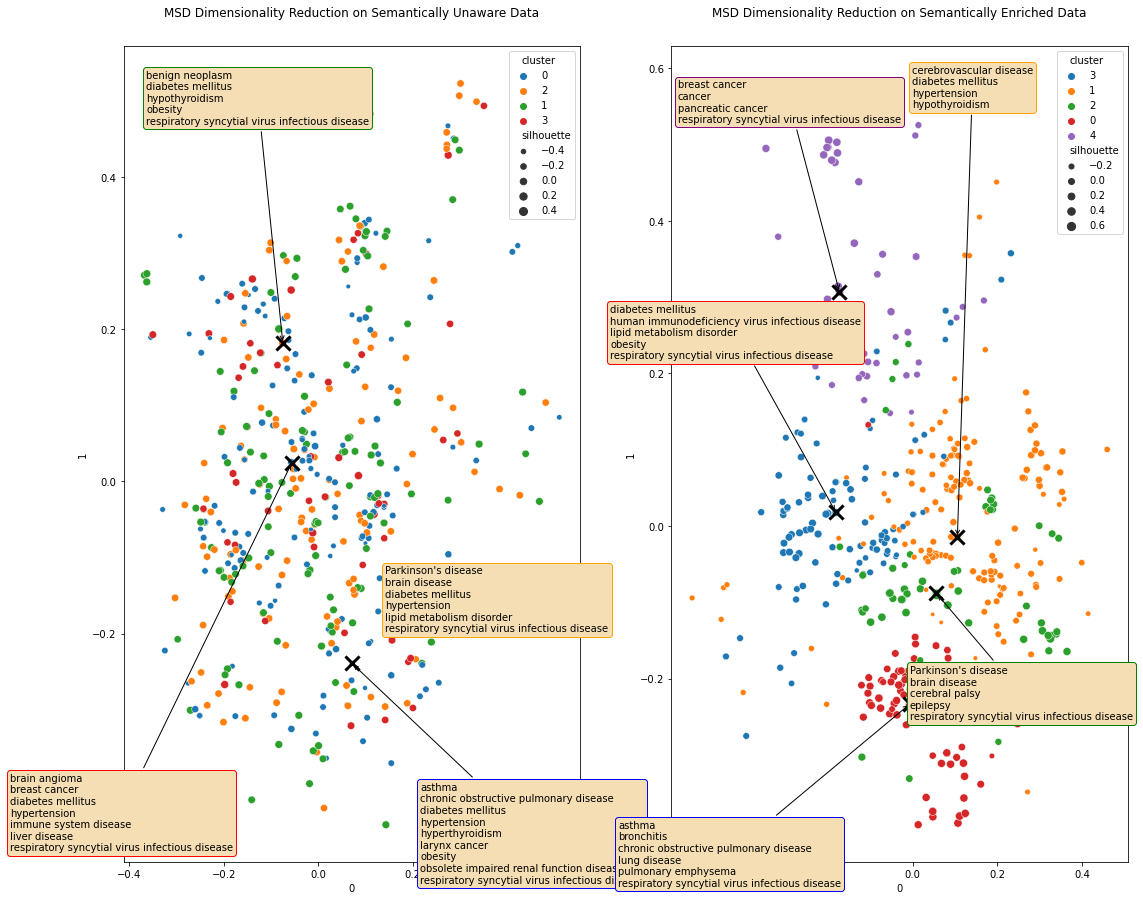

In [189]:
c = dict.fromkeys(range(4))
for i in range(4):
    c[i] = list()
    for j in range(4):
        c[i].append((diseases_names.loc[sil_cos[sil_cos.cluster==i]['index']].iloc[j].dropna().values))
    c[i] = list(np.unique(np.concatenate(c[i])))
    
w = dict.fromkeys(range(5))
for i in w:
    w[i] = list()
    for j in range(4):
        w[i].append((diseases_names.loc[sil_wang[sil_wang.cluster==i]['index']].iloc[j].dropna().values))
    w[i] = list(np.unique(np.concatenate(w[i])))





f, axs = plt.subplots(1, 2, figsize=(18,15))

axs[0].set_title("MSD Dimensionality Reduction on Semantically Unaware Data", pad=30)

sns.scatterplot(data = c_embedding,
                x = 0,
                y = 1,
                hue = no_semantic_cluster.drop(23).iloc[:,0].map(str),
                size = sil_cos.set_index('index')['silhouette'],
                ax = axs[0])

axs[0].scatter(x = c_embedding.loc[no_sem_medoids,0],
               y = c_embedding.loc[no_sem_medoids,1],
               color='black',
               marker='x',s=200,linewidth=3)


axs[1].set_title("MSD Dimensionality Reduction on Semantically Enriched Data", pad=30)

sns.scatterplot(data = w_embedding,
                x = 0,
                y = 1,
                hue = semantic_cluster.drop(23).iloc[:,0].map(str),
                ax = axs[1],
                size = sil_wang.set_index('index')['silhouette'],
                s=18)

axs[1].scatter(x = w_embedding.loc[sem_medoids,0],
               y = w_embedding.loc[sem_medoids,1],
               marker='x',
               color = 'black',
               s=200,
               linewidth=3)



pos = {0:[(180, -170),(70, 25),(-25, 245),(-170,-350)],
       1:[(-180, -150),(15, 450),(85, -100),(-100, 180),(-50, 190)]}

d = {0:[c_embedding,no_sem_medoids,c],
    1:[w_embedding,sem_medoids,w]}

for n in range(2):
    
    for i in d[n][2]:
        
        offsetbox = TextArea(",".join(d[n][2][i]).replace(',','\n'))

        ab = AnnotationBbox(offsetbox,
                            (d[n][0].loc[d[n][1],0].iloc[i],
                             d[n][0].loc[d[n][1],1].iloc[i]),
                            xybox=pos[n][i],
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"),bboxprops = 
                            dict(facecolor='wheat',boxstyle='round'
                                 ,edgecolor=['blue','orange','green','red','purple'][i]))
        
        axs[n].add_artist(ab)

plt.savefig("Data Post-Processing figure.svg")
plt.show()